# Comparaison of Brain Tumor MRI Detection with Neural Networks vs. Traditional Machine Learning Models

## Team Members
- Mohammad Ali Zahir - ID: 40077619
- Marwa Khalid - ID: 40155098

## Required Librairies
**Run the cell below to install all the required libraries.**

In [3]:
# !pip install matplotlib
# !pip install pandas
# !pip install numpy
# !pip install seaborn
# !pip install scikit-learn
# !pip install scikit-image
# !pip install tensorflow
# !pip install tabulate

In [7]:
import matplotlib.pyplot as plt 
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from tabulate import tabulate
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")





# Displaying Data

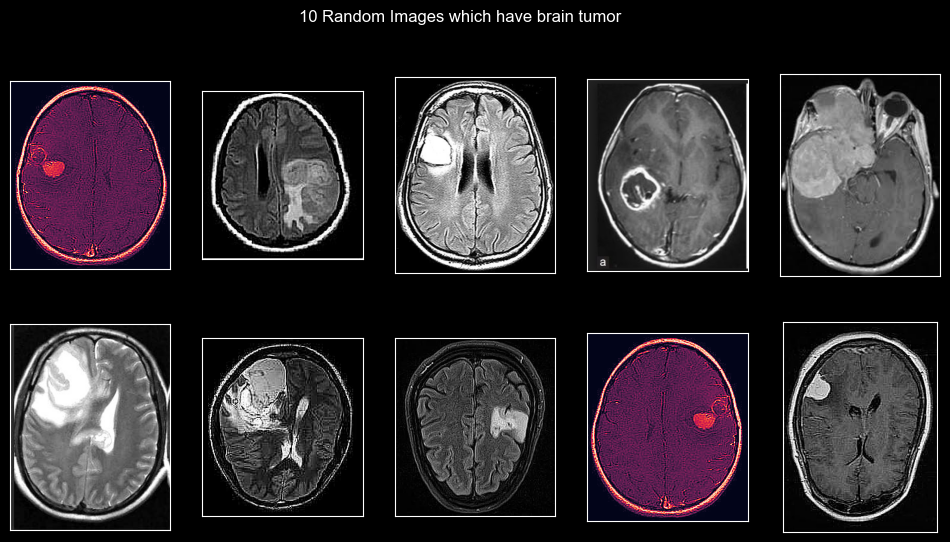

In [8]:
folder_path = "./data/yes"
image_list = os.listdir(folder_path)
random_images = random.sample(image_list, 10)

image_data = []  # List to store image data

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    image_path = os.path.join(folder_path, random_images[i])
    img = plt.imread(image_path)
    image_data.append(img)  # Append image to list
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("10 Random Images which have brain tumor")
plt.show()




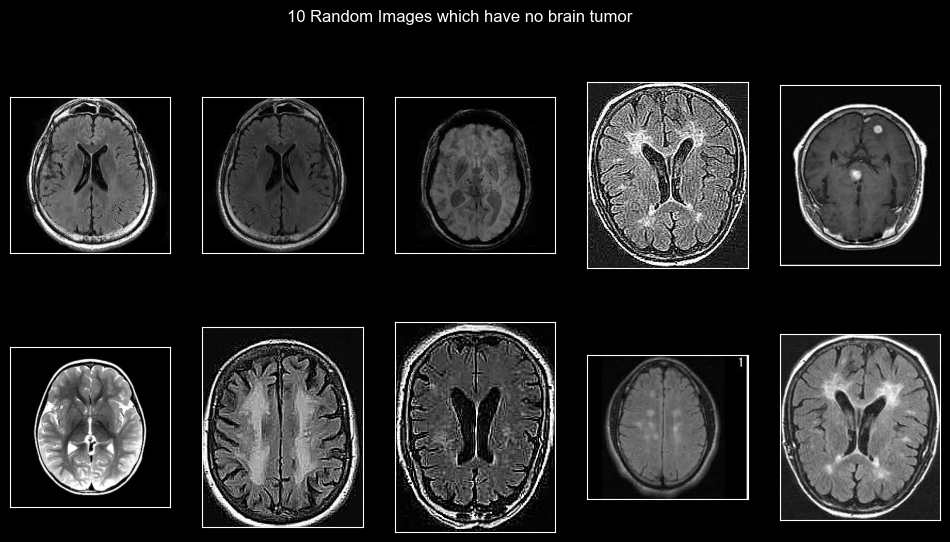

In [9]:
folder_path = "./data/no/"
image_list = os.listdir(folder_path)
random_images = random.sample(image_list, 10)

image_data = []  # List to store image data

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    image_path = os.path.join(folder_path, random_images[i])
    img = plt.imread(image_path)
    image_data.append(img)  # Append image to list
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("10 Random Images which have no brain tumor")
plt.show()




# Normalizing and training the data

In [10]:
data_folder = "./data"
image_extensions = [".jpg", ".jpeg"]  # List of image extensions

# Get list of files in the folders
yes_folder = os.path.join(data_folder, "yes")
yes_files = [os.path.join(yes_folder, f) for f in os.listdir(yes_folder) if os.path.splitext(f)[1].lower() in image_extensions]

no_folder = os.path.join(data_folder, "no")
no_files = [os.path.join(no_folder, f) for f in os.listdir(no_folder) if os.path.splitext(f)[1].lower() in image_extensions]

# Combine the lists of files and create target labels
image_files = yes_files + no_files
target = np.concatenate([np.ones(len(yes_files)), np.zeros(len(no_files))])

# Shuffle and split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(image_files, target, test_size=0.2, random_state=42)


def load_images(image_list):
    images = []
    for image_path in image_list:
        img = plt.imread(image_path)
        img_resized = resize(img, (150, 150, 3))  # Resize to (150, 150, 3) shape
        img_norm = img_resized / 255.0  # Normalize to [0, 1] range
        images.append(img_norm)
    return np.array(images)



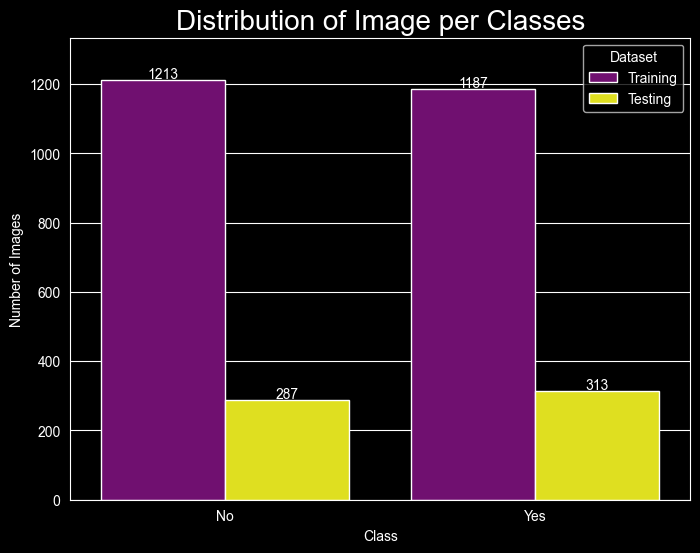

In [11]:
# Count the number of images for each class in the training and testing datasets
train_counts = np.unique(y_train, return_counts=True)
test_counts = np.unique(y_test, return_counts=True)

# Combine the count values into a single data frame
counts_df = pd.DataFrame({
    "Class": ["No", "Yes"],
    "Training": train_counts[1],
    "Testing": test_counts[1]
})

# Melt the data frame into a long format
counts_melt = counts_df.melt(id_vars=["Class"], var_name="Dataset", value_name="Count")
colors = ["purple", "yellow"]
sns.set_style(style="darkgrid")
plt.style.use("dark_background")
fig = plt.figure(facecolor='black', figsize=(8, 6))

# Create a bar plot with the count values displayed above each bar
ax = sns.barplot(x="Class", y="Count", hue="Dataset", data=counts_melt, palette=colors)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.ylim([0, max(counts_melt["Count"]) * 1.1])
for patch in ax.patches:
    height = patch.get_height()
    x = patch.get_x() + patch.get_width() / 2
    y = height + 5
    ax.text(x, y, str(int(height)), ha="center")

plt.title("Distribution of Image per Classes" , fontdict={'size':20})
plt.show()

# Neural Network Models

## Model 1: ConvNet CNN Model

In [50]:

# Load and normalize the images
X_train_norm = np.array(load_images(X_train))
X_test_norm = np.array(load_images(X_test))

# Define the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(1, activation="sigmoid")
])

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model for 20 epochs
history = model.fit(X_train_norm, y_train, epochs=20, validation_data=(X_test_norm, y_test))




Epoch 1/20
76/76 [==============================] - 3s 13ms/step - loss: 0.6922 - accuracy: 0.5060 - val_loss: 0.6812 - val_accuracy: 0.5100
Epoch 2/20
76/76 [==============================] - 1s 9ms/step - loss: 0.5916 - accuracy: 0.6984 - val_loss: 0.5235 - val_accuracy: 0.7093
Epoch 3/20
76/76 [==============================] - 1s 9ms/step - loss: 0.5034 - accuracy: 0.7528 - val_loss: 0.4880 - val_accuracy: 0.7724
Epoch 4/20
76/76 [==============================] - 1s 9ms/step - loss: 0.4532 - accuracy: 0.7835 - val_loss: 0.4476 - val_accuracy: 0.7874
Epoch 5/20
76/76 [==============================] - 1s 9ms/step - loss: 0.3917 - accuracy: 0.8247 - val_loss: 0.3822 - val_accuracy: 0.8256
Epoch 6/20
76/76 [==============================] - 1s 9ms/step - loss: 0.3240 - accuracy: 0.8633 - val_loss: 0.3337 - val_accuracy: 0.8405
Epoch 7/20
76/76 [==============================] - 1s 10ms/step - loss: 0.2640 - accuracy: 0.8920 - val_loss: 0.2770 - val_accuracy: 0.8987
Epoch 8/20
76/76 [

In [51]:
# Generate predictions on the validation set
y_pred = model.predict(X_test_norm)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Generate a classification report
report = classification_report(y_test, y_pred_binary, output_dict=True)

# Convert the dictionary to a pandas dataframe and format the values as percentages
df_cnn = pd.DataFrame(report).transpose()
df_cnn.loc[:, 'precision':'f1-score'] = df_cnn.loc[:, 'precision':'f1-score'].applymap(lambda x: f'{x:.2%}')

# Print the dataframe
report_table = tabulate(df_cnn.drop('accuracy'), headers='keys', tablefmt="grid",
                        stralign="right", numalign="right")
print(report_table)

# Print the accuracy
accuracy = accuracy_score(y_test, y_pred_binary) * 100
print(f"\nCNN accuracy: {accuracy:.2f}%")

19/19 [==============================] - 0s 4ms/step
+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
+==============+=============+==========+============+===========+
|          0.0 |      97.32% |   98.31% |     97.81% |       295 |
+--------------+-------------+----------+------------+-----------+
|          1.0 |      98.36% |   97.39% |     97.87% |       307 |
+--------------+-------------+----------+------------+-----------+
|    macro avg |      97.84% |   97.85% |     97.84% |       602 |
+--------------+-------------+----------+------------+-----------+
| weighted avg |      97.85% |   97.84% |     97.84% |       602 |
+--------------+-------------+----------+------------+-----------+

CNN accuracy: 97.84%


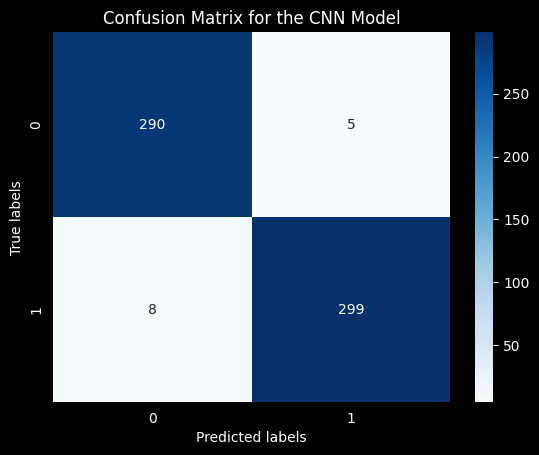

In [52]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")

# Set the labels and title of the plot
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix for the CNN Model")

plt.show()

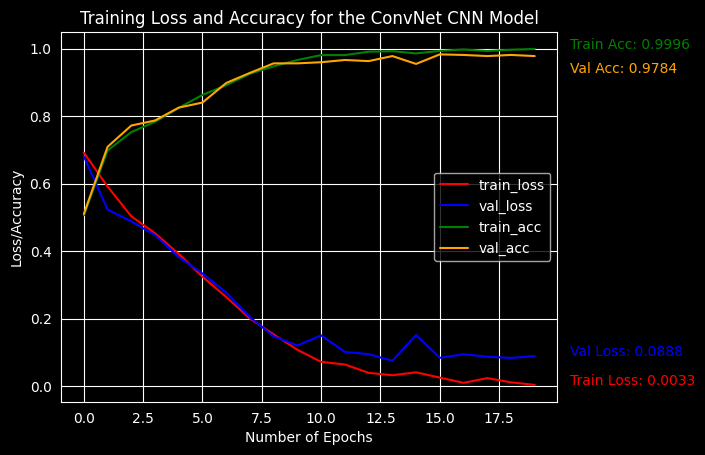

In [53]:
# plot the training loss and accuracy with dark background and dark plot
plt.style.use("dark_background")
fig = plt.figure(facecolor='black')
plt.plot(history.history["loss"], color='red', label="train_loss")
plt.plot(history.history["val_loss"], color='blue', label="val_loss")
plt.plot(history.history["accuracy"], color='green', label="train_acc")
plt.plot(history.history["val_accuracy"], color='orange', label="val_acc")
plt.title("Training Loss and Accuracy for the ConvNet CNN Model", color='white')
plt.xlabel("Number of Epochs", color='white')
plt.ylabel("Loss/Accuracy", color='white')
plt.legend(loc="center right")

# Get final training and validation loss/accuracy values
train_loss_final = round(history.history["loss"][-1], 4)
val_loss_final = round(history.history["val_loss"][-1], 4)
train_acc_final = round(history.history["accuracy"][-1], 4)
val_acc_final = round(history.history["val_accuracy"][-1], 4)

# Add final values to the plot
plt.text(len(history.history["loss"])+0.5, train_loss_final, f'Train Loss: {train_loss_final}', fontsize=10, color='red')
plt.text(len(history.history["val_loss"]) +0.5, val_loss_final, f'Val Loss: {val_loss_final}', fontsize=10, color='blue')
plt.text(len(history.history["accuracy"]) +0.5, train_acc_final, f'Train Acc: {train_acc_final}', fontsize=10, color='green')
plt.text(len(history.history["val_accuracy"])+0.5, val_acc_final-0.05, f'Val Acc: {val_acc_final}', fontsize=10, color='orange')

plt.show()



## Model 2: Multilayer Perceptron

In [46]:
# Load and normalize the images
X_train_norm = np.array(load_images(X_train))
X_test_norm = np.array(load_images(X_test))

# Define the model architecture
model = Sequential([
    Flatten(input_shape=(150, 150, 3)),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")
])

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model for 20 epochs
history = model.fit(X_train_norm, y_train, epochs=20, validation_data=(X_test_norm, y_test))




Epoch 1/20
76/76 [==============================] - 2s 9ms/step - loss: 0.5575 - accuracy: 0.6959 - val_loss: 0.4928 - val_accuracy: 0.7857
Epoch 2/20
76/76 [==============================] - 1s 7ms/step - loss: 0.4269 - accuracy: 0.7998 - val_loss: 0.4872 - val_accuracy: 0.8272
Epoch 3/20
76/76 [==============================] - 1s 7ms/step - loss: 0.3618 - accuracy: 0.8459 - val_loss: 0.4979 - val_accuracy: 0.8106
Epoch 4/20
76/76 [==============================] - 0s 6ms/step - loss: 0.3029 - accuracy: 0.8783 - val_loss: 0.3416 - val_accuracy: 0.8455
Epoch 5/20
76/76 [==============================] - 0s 6ms/step - loss: 0.2332 - accuracy: 0.9194 - val_loss: 0.3132 - val_accuracy: 0.8854
Epoch 6/20
76/76 [==============================] - 0s 6ms/step - loss: 0.1816 - accuracy: 0.9443 - val_loss: 0.2350 - val_accuracy: 0.9219
Epoch 7/20
76/76 [==============================] - 1s 7ms/step - loss: 0.1643 - accuracy: 0.9485 - val_loss: 0.2244 - val_accuracy: 0.9120
Epoch 8/20
76/76 [==

In [47]:
# Generate predictions on the validation set
y_pred = model.predict(X_test_norm)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Generate a classification report
report = classification_report(y_test, y_pred_binary, output_dict=True)

# Convert the dictionary to a pandas dataframe and format the values as percentages
df_cnn = pd.DataFrame(report).transpose()
df_cnn.loc[:, 'precision':'f1-score'] = df_cnn.loc[:, 'precision':'f1-score'].applymap(lambda x: f'{x:.2%}')

# Print the dataframe
report_table = tabulate(df_cnn.drop('accuracy'), headers='keys', tablefmt="grid",
                        stralign="right", numalign="right")
print(report_table)

# Print the accuracy
accuracy = accuracy_score(y_test, y_pred_binary) * 100
print(f"\nMLP accuracy: {accuracy:.2f}%")

19/19 [==============================] - 0s 4ms/step
+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
+==============+=============+==========+============+===========+
|          0.0 |      97.92% |   95.93% |     96.92% |       295 |
+--------------+-------------+----------+------------+-----------+
|          1.0 |      96.17% |   98.05% |     97.10% |       307 |
+--------------+-------------+----------+------------+-----------+
|    macro avg |      97.05% |   96.99% |     97.01% |       602 |
+--------------+-------------+----------+------------+-----------+
| weighted avg |      97.03% |   97.01% |     97.01% |       602 |
+--------------+-------------+----------+------------+-----------+

MLP accuracy: 97.01%


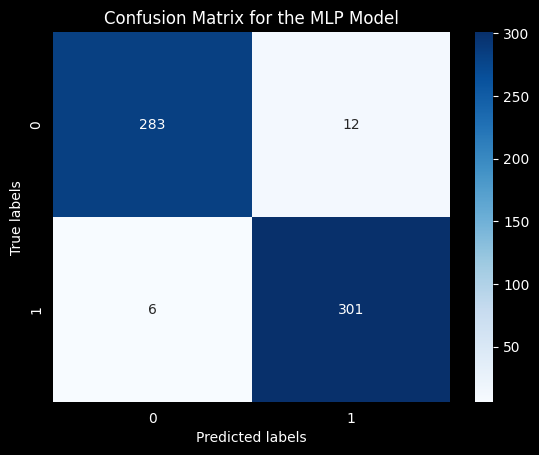

In [48]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")

# Set the labels and title of the plot
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix for the MLP Model")

plt.show()


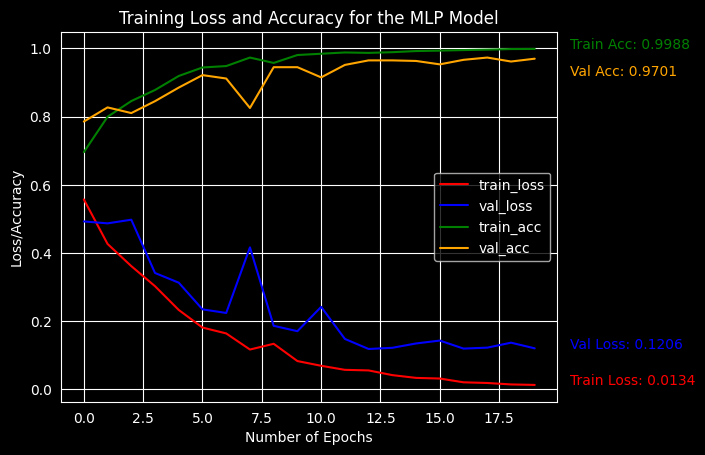

In [49]:
# plot the training loss and accuracy with dark background and dark plot
plt.style.use("dark_background")
fig = plt.figure(facecolor='black')
plt.plot(history.history["loss"], color='red', label="train_loss")
plt.plot(history.history["val_loss"], color='blue', label="val_loss")
plt.plot(history.history["accuracy"], color='green', label="train_acc")
plt.plot(history.history["val_accuracy"], color='orange', label="val_acc")
plt.title("Training Loss and Accuracy for the MLP Model", color='white')
plt.xlabel("Number of Epochs", color='white')
plt.ylabel("Loss/Accuracy", color='white')
plt.legend(loc="center right")

# Get final training and validation loss/accuracy values
train_loss_final = round(history.history["loss"][-1], 4)
val_loss_final = round(history.history["val_loss"][-1], 4)
train_acc_final = round(history.history["accuracy"][-1], 4)
val_acc_final = round(history.history["val_accuracy"][-1], 4)

# Add final values to the plot
plt.text(len(history.history["loss"])+0.5, train_loss_final, f'Train Loss: {train_loss_final}', fontsize=10, color='red')
plt.text(len(history.history["val_loss"]) +0.5, val_loss_final, f'Val Loss: {val_loss_final}', fontsize=10, color='blue')
plt.text(len(history.history["accuracy"]) +0.5, train_acc_final, f'Train Acc: {train_acc_final}', fontsize=10, color='green')
plt.text(len(history.history["val_accuracy"])+0.5, val_acc_final-0.05, f'Val Acc: {val_acc_final}', fontsize=10, color='orange')

plt.show()


## Model 3: ResNet50 Model

In [39]:
# Load and normalize the images
X_train_norm = np.array(load_images(X_train))
X_test_norm = np.array(load_images(X_test))

# Define the ResNet50 model
resnet_model = ResNet50(include_top=False, weights=None, input_shape=(150, 150, 3))

# Add custom output layers
x = resnet_model.output
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)

# Compile the model
model = Model(inputs=resnet_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

# Train the model for 20 epochs
history = model.fit(X_train_norm, y_train, epochs=20, validation_data=(X_test_norm, y_test))





Epoch 1/20
76/76 [==============================] - 43s 65ms/step - loss: 0.9828 - accuracy: 0.6265 - val_loss: 0.7229 - val_accuracy: 0.4900
Epoch 2/20
76/76 [==============================] - 4s 49ms/step - loss: 0.5353 - accuracy: 0.7378 - val_loss: 0.7751 - val_accuracy: 0.4900
Epoch 3/20
76/76 [==============================] - 4s 49ms/step - loss: 0.3979 - accuracy: 0.8197 - val_loss: 0.8615 - val_accuracy: 0.4900
Epoch 4/20
76/76 [==============================] - 4s 49ms/step - loss: 0.3227 - accuracy: 0.8583 - val_loss: 1.5312 - val_accuracy: 0.4900
Epoch 5/20
76/76 [==============================] - 4s 50ms/step - loss: 0.2268 - accuracy: 0.9086 - val_loss: 2.0119 - val_accuracy: 0.4900
Epoch 6/20
76/76 [==============================] - 4s 49ms/step - loss: 0.1974 - accuracy: 0.9206 - val_loss: 0.8729 - val_accuracy: 0.4917
Epoch 7/20
76/76 [==============================] - 4s 50ms/step - loss: 0.1464 - accuracy: 0.9514 - val_loss: 0.8669 - val_accuracy: 0.5133
Epoch 8/20
7

In [40]:
# Generate predictions on the validation set
y_pred = model.predict(X_test_norm)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Generate a classification report
report = classification_report(y_test, y_pred_binary, output_dict=True)

# Convert the dictionary to a pandas dataframe and format the values as percentages
df_cnn = pd.DataFrame(report).transpose()
df_cnn.loc[:, 'precision':'f1-score'] = df_cnn.loc[:, 'precision':'f1-score'].applymap(lambda x: f'{x:.2%}')

# Print the dataframe
report_table = tabulate(df_cnn.drop('accuracy'), headers='keys', tablefmt="grid",
                        stralign="right", numalign="right")
print(report_table)

# Print the accuracy
accuracy = accuracy_score(y_test, y_pred_binary) * 100
print(f"\nResNet50 accuracy: {accuracy:.2f}%")

19/19 [==============================] - 1s 10ms/step
+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
+==============+=============+==========+============+===========+
|          0.0 |      94.38% |   56.95% |     71.04% |       295 |
+--------------+-------------+----------+------------+-----------+
|          1.0 |      70.05% |   96.74% |     81.26% |       307 |
+--------------+-------------+----------+------------+-----------+
|    macro avg |      82.21% |   76.85% |     76.15% |       602 |
+--------------+-------------+----------+------------+-----------+
| weighted avg |      81.97% |   77.24% |     76.25% |       602 |
+--------------+-------------+----------+------------+-----------+

ResNet50 accuracy: 77.24%


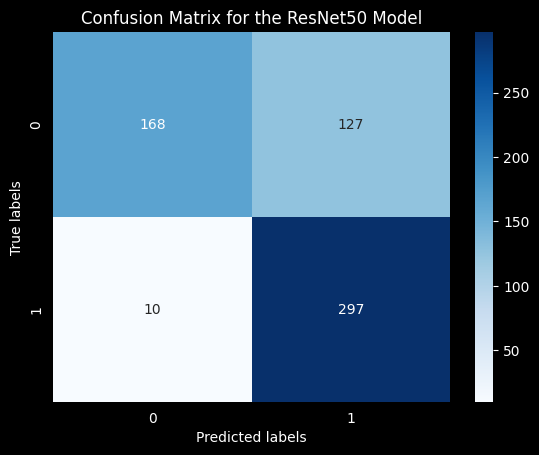

In [41]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")

# Set the labels and title of the plot
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix for the ResNet50 Model")

plt.show()


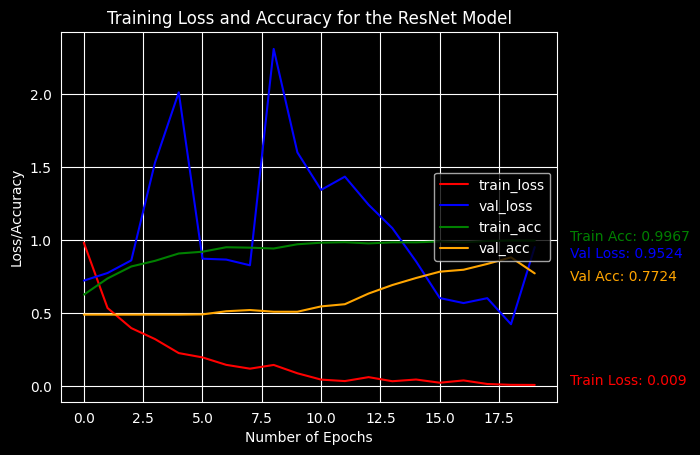

In [44]:
# plot the training loss and accuracy with dark background and dark plot
plt.style.use("dark_background")
fig = plt.figure(facecolor='black')
plt.plot(history.history["loss"], color='red', label="train_loss")
plt.plot(history.history["val_loss"], color='blue', label="val_loss")
plt.plot(history.history["accuracy"], color='green', label="train_acc")
plt.plot(history.history["val_accuracy"], color='orange', label="val_acc")
plt.title("Training Loss and Accuracy for the ResNet Model", color='white')
plt.xlabel("Number of Epochs", color='white')
plt.ylabel("Loss/Accuracy", color='white')
plt.legend(loc="center right")

# Get final training and validation loss/accuracy values
train_loss_final = round(history.history["loss"][-1], 4)
val_loss_final = round(history.history["val_loss"][-1], 4)
train_acc_final = round(history.history["accuracy"][-1], 4)
val_acc_final = round(history.history["val_accuracy"][-1], 4)

# Add final values to the plot
plt.text(len(history.history["loss"])+0.5, train_loss_final, f'Train Loss: {train_loss_final}', fontsize=10, color='red')
plt.text(len(history.history["val_loss"]) +0.5, val_loss_final-0.07, f'Val Loss: {val_loss_final}', fontsize=10, color='blue')
plt.text(len(history.history["accuracy"]) +0.5, train_acc_final, f'Train Acc: {train_acc_final}', fontsize=10, color='green')
plt.text(len(history.history["val_accuracy"])+0.5, val_acc_final-0.05, f'Val Acc: {val_acc_final}', fontsize=10, color='orange')

plt.show()


# Machine Learning Models

## Model 4: K-Nearest Neighbors

In [ ]:
# Create the knn model with the best parameters
# Load and normalize the images

X_train_norm = np.array(load_images(X_train))
X_test_norm = np.array(load_images(X_test))

# Flatten the images
X_train_flat = X_train_norm.reshape(X_train_norm.shape[0], -1)
X_test_flat = X_test_norm.reshape(X_test_norm.shape[0], -1)

# Perform k-nearest neighbor classification
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_flat, y_train)
y_pred = knn.predict(X_test_flat)

# Print the classification report
report = classification_report(y_test, y_pred, output_dict=True)
# Convert the dictionary to a pandas dataframe
df_nb = pd.DataFrame(report).transpose()

# Format the values as percentages
df_nb.loc[:, 'precision':'f1-score'] = df_nb.loc[:, 'precision':'f1-score'].applymap(lambda x: f'{x:.2%}')

# Print the dataframe
report_table = tabulate(df_nb.drop('accuracy'), headers='keys',tablefmt="grid",
            stralign="right", numalign="right")
print(report_table)

# Print the accuracy
accuracy = accuracy_score(y_test, y_pred) * 100
print(f"\nk-Nearest Neighbor accuracy: {accuracy:.2f}%")

+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
+==============+=============+==========+============+===========+
|          0.0 |      95.42% |   98.98% |     97.17% |       295 |
+--------------+-------------+----------+------------+-----------+
|          1.0 |      98.99% |   95.44% |     97.18% |       307 |
+--------------+-------------+----------+------------+-----------+
|    macro avg |      97.21% |   97.21% |     97.18% |       602 |
+--------------+-------------+----------+------------+-----------+
| weighted avg |      97.24% |   97.18% |     97.18% |       602 |
+--------------+-------------+----------+------------+-----------+

k-Nearest Neighbor accuracy: 97.18%


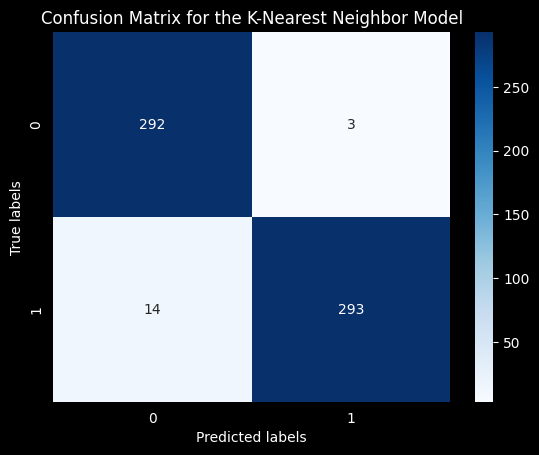

In [ ]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")

# Set the labels and title of the plot
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix for the K-Nearest Neighbor Model")

plt.show()


## Model 5: Support Vector Machine

In [ ]:
# Create the SVM model with the best parameters
# Load and normalize the images
X_train_norm = np.array(load_images(X_train))
X_test_norm = np.array(load_images(X_test))

# Flatten the images
X_train_flat = X_train_norm.reshape(X_train_norm.shape[0], -1)
X_test_flat = X_test_norm.reshape(X_test_norm.shape[0], -1)

# Define the SVM model
svm_model = SVC(C=10, kernel='rbf', degree=2)

svm_model.fit(X_train_flat, y_train)

# Predict the test data using the optimized model
y_pred = svm_model.predict(X_test_flat)

# Print the classification report
report = classification_report(y_test, y_pred, output_dict=True)
# Convert the dictionary to a pandas dataframe
df_svm = pd.DataFrame(report).transpose()

# Format the values as percentages
df_svm.loc[:, 'precision':'f1-score'] = df_svm.loc[:, 'precision':'f1-score'].applymap(lambda x: f'{x:.2%}')

# Print the dataframe
report_table = tabulate(df_svm.drop('accuracy'), headers='keys',tablefmt="grid",
            stralign="right", numalign="right")
print(report_table)

# Print the SVM accuracy
accuracy = accuracy_score(y_test, y_pred) * 100
print(f"\nSVM accuracy: {accuracy:.2f}%")


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
+==============+=============+==========+============+===========+
|          0.0 |      97.64% |   97.97% |     97.80% |       295 |
+--------------+-------------+----------+------------+-----------+
|          1.0 |      98.04% |   97.72% |     97.88% |       307 |
+--------------+-------------+----------+------------+-----------+
|    macro avg |      97.84% |   97.84% |     97.84% |       602 |
+--------------+-------------+----------+------------+-----------+
| weighted avg |      97.84% |   97.84% |     97.84% |       602 |
+--------------+-------------+----------+------------+-----------+

SVM accuracy: 97.84%


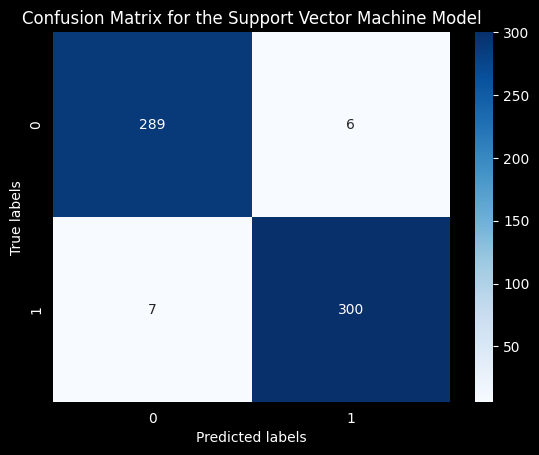

In [ ]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")

# Set the labels and title of the plot
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix for the Support Vector Machine Model")

plt.show()


## Model 6: Random Forest Model

In [ ]:
# Load and normalize the images
X_train_norm = np.array(load_images(X_train))
X_test_norm = np.array(load_images(X_test))

# Flatten the images
X_train_flat = X_train_norm.reshape(X_train_norm.shape[0], -1)
X_test_flat = X_test_norm.reshape(X_test_norm.shape[0], -1)

# Define the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Train the Random Forest model
rf_model.fit(X_train_flat, y_train)

# Predict the test data using the trained model
y_pred = rf_model.predict(X_test_flat)

# Print the classification report
report = classification_report(y_test, y_pred, output_dict=True)
# Convert the dictionary to a pandas dataframe
df_rf = pd.DataFrame(report).transpose()

# Format the values as percentages
df_rf.loc[:, 'precision':'f1-score'] = df_rf.loc[:, 'precision':'f1-score'].applymap(lambda x: f'{x:.2%}')

# Print the dataframe
report_table = tabulate(df_rf.drop('accuracy'), headers='keys',tablefmt="grid",
            stralign="right", numalign="right")
print(report_table)

# Print the Random Forest accuracy
accuracy = accuracy_score(y_test, y_pred) * 100
print(f"\nRandom Forest accuracy: {accuracy:.2f}%")


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
+==============+=============+==========+============+===========+
|          0.0 |      94.72% |   91.19% |     92.92% |       295 |
+--------------+-------------+----------+------------+-----------+
|          1.0 |      91.82% |   95.11% |     93.44% |       307 |
+--------------+-------------+----------+------------+-----------+
|    macro avg |      93.27% |   93.15% |     93.18% |       602 |
+--------------+-------------+----------+------------+-----------+
| weighted avg |      93.24% |   93.19% |     93.18% |       602 |
+--------------+-------------+----------+------------+-----------+

Random Forest accuracy: 93.19%


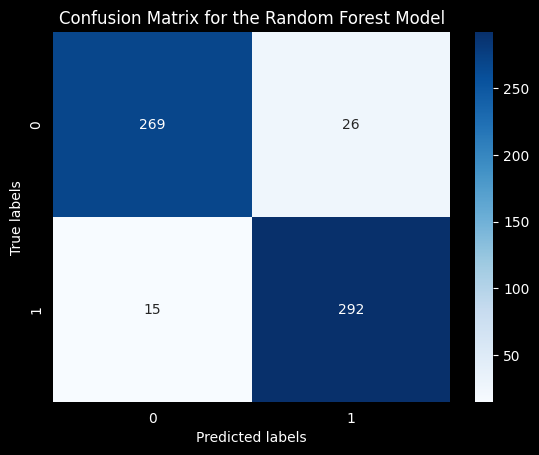

In [ ]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")

# Set the labels and title of the plot
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix for the Random Forest Model")

plt.show()
